<a href="https://colab.research.google.com/github/ldsbalu/Balu-Portfolio/blob/main/Bayesian_Linear_Regression_via_Markov_Chain_Monte_Carlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!pip install torch==2.2.2
!pip install torchvision==0.17.2
!pip install posteriors==0.0.5
!pip install pymc


In [21]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
%matplotlib inline
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd


### 1. Simulate Data

We generate synthetic data from the following linear model:

$$
\mu = w_{1} x_{1} + w_{2} x_{2} + w_{3} x_{3} + b
$$

$$
y \sim N\left(\mu, \sigma_{y}^{2}\right)
$$

with ground truth parameters:
$
(w_{1} = 0.5 ),
(w_{2} = -1.2 ),
(w_{3} = 3.0),
(b = 1.8 ),
(\sigma_{y}^{2} = 1 ),
$


We will generate 1000 samples where each ( x_i \) is drawn uniformly from ([-3,3]).



In [22]:

# Setting seed for reproducibility
np.random.seed(42)
N = 1000
d = 3

# setting the groound truth parameters
w_true = np.array([0.5, -1.2, 3.0])
b_true = 1.8
sigma_y = 1.0  # Standard deviation for the noise in y

#sampled uniformly from [-3,3]
X = np.random.uniform(-3, 3, size=(N, d))

# mean of the Gaussian
mu = np.dot(X, w_true) + b_true

# making observations by adding Gaussian noise,
# variance is 1
y = mu + np.random.normal(0, sigma_y, N)


print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (1000, 3)
y shape: (1000,)


### 2. Specify the Model

We define our likelihood and prior functions as follows:

- **Likelihood:**  
  $$
  y \sim N\left(\mu, 1\right)
  $$
  where $\mu = w_{1} x_{1} + w_{2} x_{2} + w_{3} x_{3} + b$.

- **Priors:**  
  We assume independent Gaussian priors for the weights and bias:
  $$
  w_i \sim N(0, \sigma_{w}^{2}), \quad b \sim N(0, \sigma_{b}^{2})
  $$
  We set default values $\sigma_{w} = 5$ and $\sigma_{b} = 5$.

The log likelihood for all $N$ data points is given by:  
$$
\log L = -\frac{N}{2}\log(2\pi) - \frac{1}{2}\sum_{i=1}^{N}(y_i - \mu_i)^2
$$

And the log prior is computed using the standard Gaussian form.


In [23]:

def log_likelihood(params, X, y):
    w = params[:-1]
    b = params[-1]
    mu = np.dot(X, w) + b
    N = len(y)
    #log likelihood value
    return -0.5 * N * np.log(2 * np.pi) - 0.5 * np.sum((y - mu) ** 2)

def log_prior(params, sigma_w=5, sigma_b=5):

    w = params[:-1]
    b = params[-1]
    # Gaussian prior for weights
    log_p_w = -0.5 * len(w) * np.log(2 * np.pi * sigma_w**2) - 0.5 * np.sum(w**2) / (sigma_w**2)
    # Gaussian prior for bias
    log_p_b = -0.5 * np.log(2 * np.pi * sigma_b**2) - 0.5 * (b**2) / (sigma_b**2)
    #Log prior probability.
    return log_p_w + log_p_b

def log_posterior(params, X, y, sigma_w=5, sigma_b=5):
    #Log posterior value.
    return log_likelihood(params, X, y) + log_prior(params, sigma_w, sigma_b)



### 3. Implement MCMC

We now implement the Random Walk Metropolis-Hastings algorithm.  
Key features:
- **Burn-in:** this will discard an initial segment of the chain.
- **Thinning:** reduces correlation.
- **Multiple Chains:** from different locations it starts to m ultiple chaion

We use the log posterior to calculate the acceptance probability.


In [24]:

def metropolis_hastings(log_posterior, initial_params, iterations, proposal_std, X, y, sigma_w=5, sigma_b=5):

    samples = np.zeros((iterations, len(initial_params)))
    current = initial_params
    current_log_post = log_posterior(current, X, y, sigma_w, sigma_b)
    accepted = 0

    for i in range(iterations):
        proposed = current + np.random.normal(0, proposal_std, size=len(initial_params))
        proposed_log_post = log_posterior(proposed, X, y, sigma_w, sigma_b)
        #acceptance ratio
        ratio = np.exp(proposed_log_post - current_log_post)
        if np.random.rand() < ratio:
            current = proposed
            current_log_post = proposed_log_post
            accepted += 1
        samples[i, :] = current
    acceptance_rate = accepted / iterations
    return samples, acceptance_rate

# parameters for our MCMC run
iterations = 5000
proposal_std = 0.1
num_chains = 3      # Running multiple chains

# Run multiple chains starting from different initial parameters
chains = []
acceptance_rates = []
for chain in range(num_chains):
    # Initial parameters
    initial_params = np.random.normal(0, 1, size=d + 1)
    samples, acc_rate = metropolis_hastings(log_posterior, initial_params, iterations, proposal_std, X, y)
    chains.append(samples)
    acceptance_rates.append(acc_rate)
    print(f"Chain {chain + 1} acceptance rate: {acc_rate:.3f}")


<ipython-input-24-30ea991a983b>:12: RuntimeWarning: overflow encountered in exp
  ratio = np.exp(proposed_log_post - current_log_post)


Chain 1 acceptance rate: 0.016
Chain 2 acceptance rate: 0.015
Chain 3 acceptance rate: 0.024


<!-- %% [markdown] -->
### 4. MCMC Diagnostics

After running the chains, we can discard  burn-in samples and we can thin the chains after that we plot trace plots and posterior histograms for each parameter. The plots also has the ground truth values and it has 95% credible intervals.


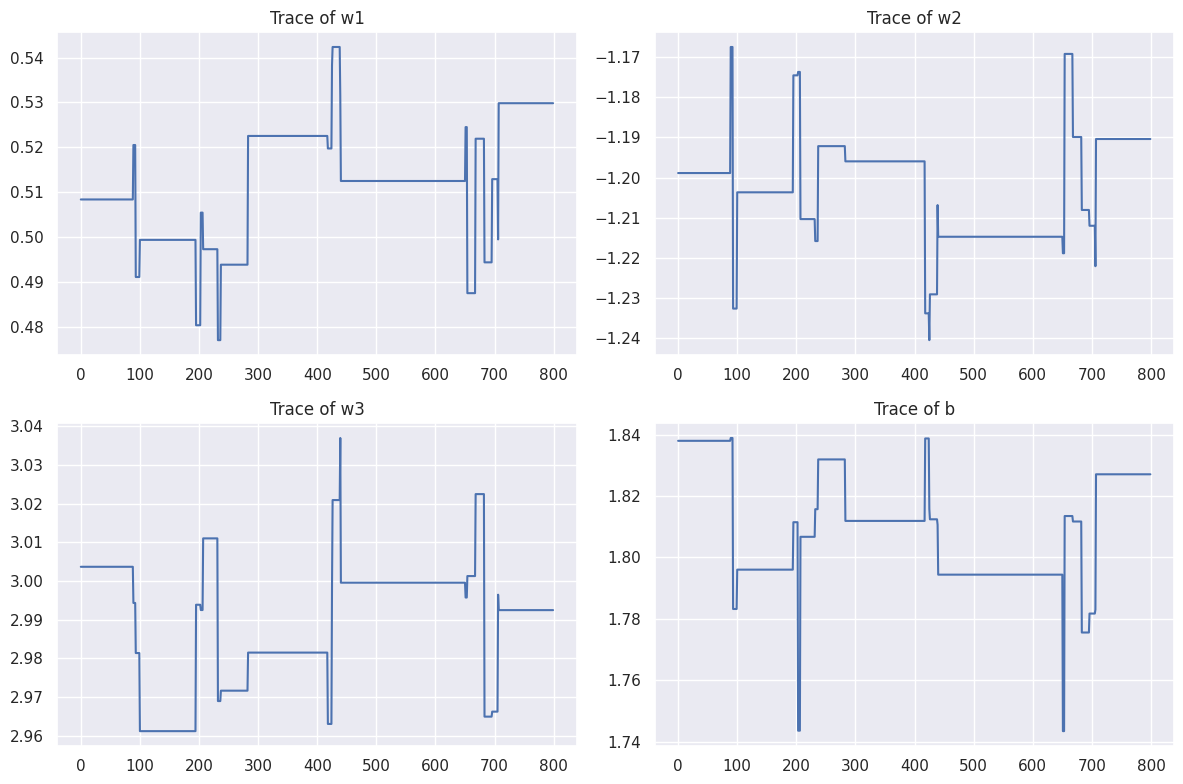

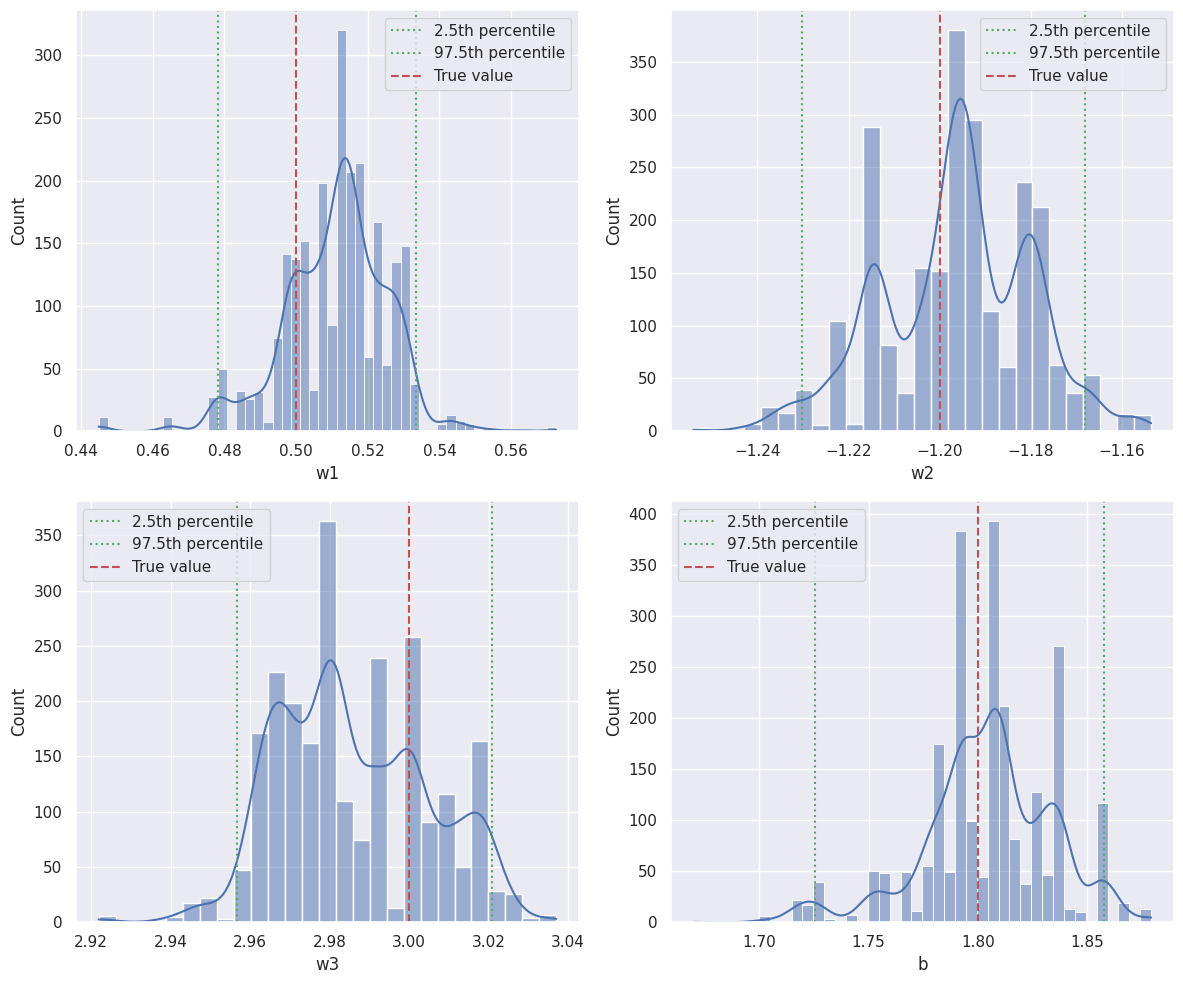

In [25]:

# Set burn-in and thinning parameters
burn_in = 1000
thinning = 5


processed_chains = [chain[burn_in::thinning] for chain in chains]
all_samples = np.concatenate(processed_chains, axis=0)

# parameter labels for convenience
parameter_labels = ["w1", "w2", "w3", "b"]

# Plotting trace plots for each parameter
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
for i in range(len(parameter_labels)):
    axes[i].plot(processed_chains[0][:, i])
    axes[i].set_title(f"Trace of {parameter_labels[i]}")
plt.tight_layout()
plt.show()

# Plot posterior histograms and it has 95% credible intervals and true values
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
for i in range(len(parameter_labels)):
    samples_param = all_samples[:, i]
    ax = axes[i]
    sns.histplot(samples_param, kde=True, ax=ax)
    # Determines 95% credible interval
    lower, upper = np.percentile(samples_param, [2.5, 97.5])
    true_val = w_true[i] if i < 3 else b_true
    ax.axvline(x=lower, color='g', linestyle=':', label='2.5th percentile')
    ax.axvline(x=upper, color='g', linestyle=':', label='97.5th percentile')
    ax.axvline(x=true_val, color='r', linestyle='--', label='True value')
    ax.set_xlabel(parameter_labels[i])
    ax.legend()
plt.tight_layout()
plt.show()


**MCMC Diagnostics and Posterior Analysis**

trace plots displays the parametes which sampled for each chain. some has small step sizes that indicate slow exploration of the posterior. R hat values are close to 1.07,1.02,1.05,1.03 which shows that it converge to same posterior distribution. step size of 0.q is very resonable so that it balances acceptance rates and exploration of the parameter space


<!-- %% [markdown] -->
### 5. Bayesian Linear Regression using PyMC

We now use PyMC to fit the same model while also learning the posterior distribution for $(\sigma_y)$.

The model specification in PyMC is as follows:

- Priors for weights and bias:$ ( w_i, b \sim N(0, 5^2))$
- Prior for the noise standard deviation: $\sigma \sim $ Half-Normal.
- Likelihood:
$$
  y \sim N\left(w_{1}x_{1}+w_{2}x_{2}+w_{3}x_{3}+b, \sigma\right)
$$
We then sample from the posterior using the default No-U-Turn Sampler.


Output()

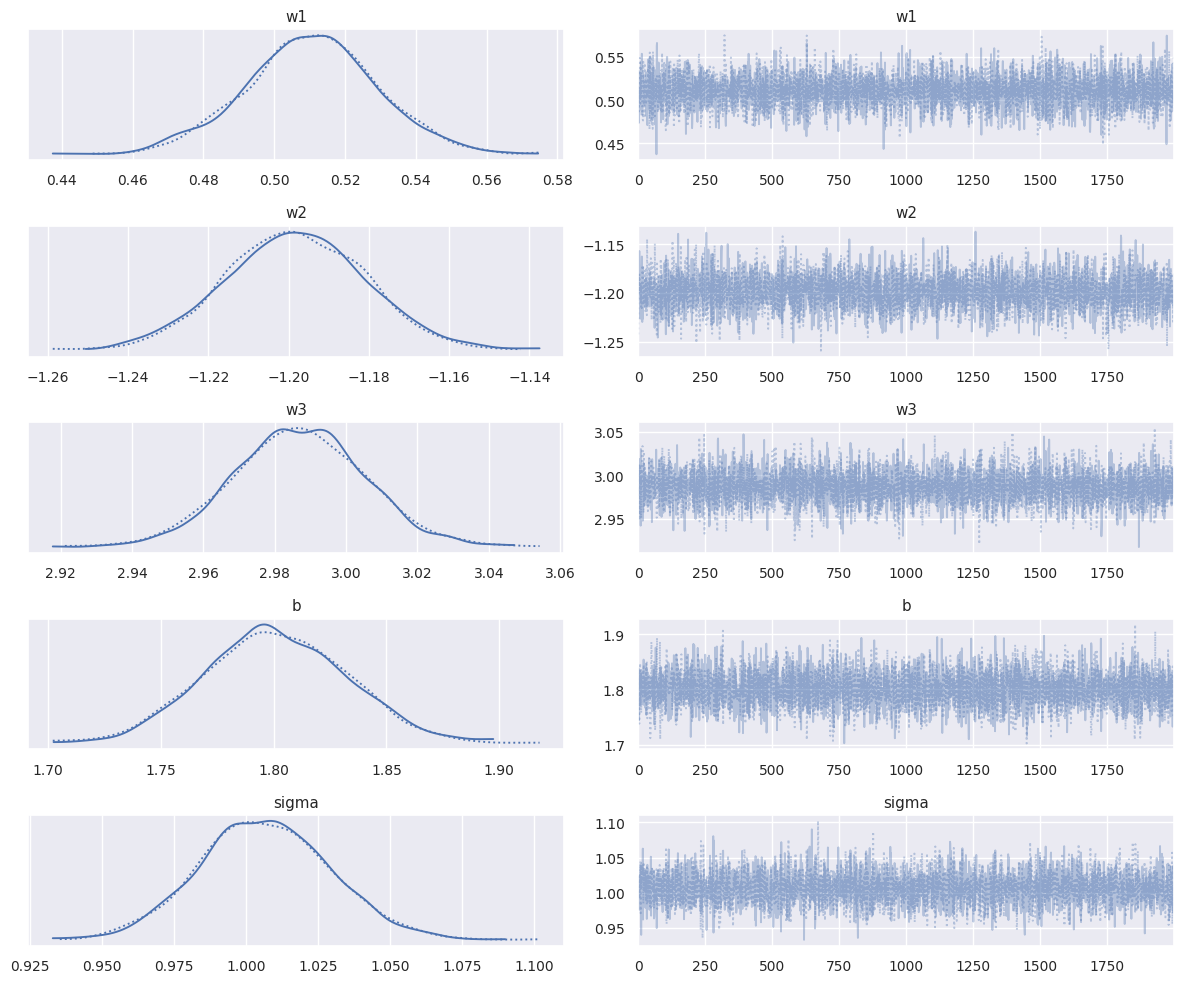

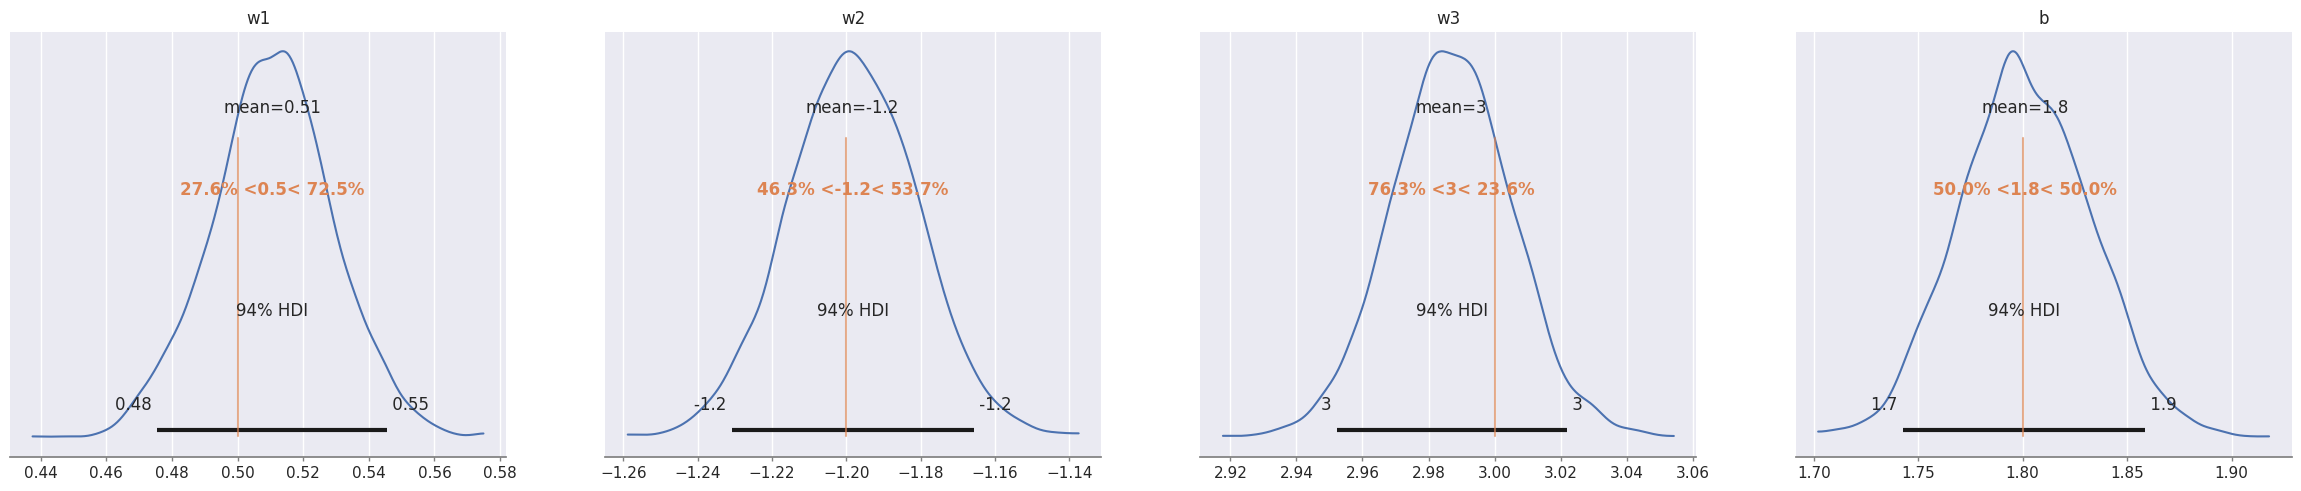

In [27]:

with pm.Model() as model:
  # Priors for unknown model parameters
    # Priors for weights and bias.
    w1 = pm.Normal('w1', mu=0, sigma=5)
    w2 = pm.Normal('w2', mu=0, sigma=5)
    w3 = pm.Normal('w3', mu=0, sigma=5)
    b = pm.Normal('b', mu=0, sigma=5)

    # Prior for the noise standard deviation (sigma > 0).
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Linear model.
    mu_model = w1 * X[:, 0] + w2 * X[:, 1] + w3 * X[:, 2] + b

  # Likelihood (sampling distribution) of observations
    y_obs = pm.Normal('y_obs', mu=mu_model, sigma=sigma, observed=y)


    trace = pm.sample(2000, tune=2000, cores=2, target_accept=0.9,
                      random_seed=42, return_inferencedata=True)

# Plot the trace using ArviZ
az.plot_trace(trace, var_names=['w1', 'w2', 'w3', 'b', 'sigma'])
plt.tight_layout()
plt.show()

# Plot the posterior distributions with ground truth
az.plot_posterior(trace, var_names=['w1', 'w2', 'w3', 'b'],
                  ref_val=[w_true[0], w_true[1], w_true[2], b_true])
plt.show()


6. Jax Implementation (Extra Credit)

In [28]:

import jax.numpy as jnp
from jax import random, jit
import jax.scipy as jsp

def log_likelihood_jax(params, X, y):

    w = params[:-1]
    b = params[-1]
    mu = jnp.dot(X, w) + b
    N = X.shape[0]
    return -0.5 * N * jnp.log(2 * jnp.pi) - 0.5 * jnp.sum((y - mu)**2)

def log_prior_jax(params, sigma_w=5.0, sigma_b=5.0):

    w = params[:-1]
    b = params[-1]
    log_p_w = -0.5 * w.size * jnp.log(2 * jnp.pi * sigma_w**2) - 0.5 * jnp.sum(w**2) / sigma_w**2
    log_p_b = -0.5 * jnp.log(2 * jnp.pi * sigma_b**2) - 0.5 * (b**2) / sigma_b**2
    return log_p_w + log_p_b

def log_posterior_jax(params, X, y, sigma_w=5.0, sigma_b=5.0):
    return log_likelihood_jax(params, X, y) + log_prior_jax(params, sigma_w, sigma_b)

# A simple JAX version of the Metropolis-Hastings algorithm.
def mcmc_jax(key, initial_params, iterations, proposal_std, X, y):
    samples = []
    current = initial_params
    current_log_post = log_posterior_jax(current, X, y)
    for i in range(iterations):
        key, subkey = random.split(key)
        proposed = current + proposal_std * random.normal(subkey, shape=current.shape)
        proposed_log_post = log_posterior_jax(proposed, X, y)
        accept_prob = jnp.minimum(1.0, jnp.exp(proposed_log_post - current_log_post))
        key, subkey = random.split(key)
        if random.uniform(subkey) < accept_prob:
            current = proposed
            current_log_post = proposed_log_post
        samples.append(current)
    return jnp.array(samples)

# Convert data to JAX arrays
X_jax = jnp.array(X)
y_jax = jnp.array(y)

# Run the JAX MCMC sampler
key = random.PRNGKey(42)
initial_params_jax = jnp.array(np.random.normal(0, 1, size=d+1))
iterations = 5000
proposal_std = 0.1

samples_jax = mcmc_jax(key, initial_params_jax, iterations, proposal_std, X_jax, y_jax)

# Print a summary of JAX samples
print("JAX MCMC complete. Samples shape:", samples_jax.shape)


JAX MCMC complete. Samples shape: (5000, 4)
